In [ ]:
from google.colab import files
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


In [ ]:
# Carregar o arquivo no ambiente
uploaded = files.upload()

# Lendo o arquivo CSV
df = pd.read_csv(next(iter(uploaded)))

StopIteration: 

In [ ]:
# Exibindo as primeiras linhas do dataset
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
# Informações gerais sobre o dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [ ]:
# Verificar a quantidade de valores nulos em cada coluna
df.isnull().sum()

,0
id,0
name,16
host_id,0
host_name,21
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0


In [ ]:
# Estatísticas descritivas das colunas numéricas
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [ ]:
# Verificar as categorias em uma coluna importante, como 'neighbourhood'
df['neighbourhood'].value_counts()

,count
neighbourhood,
Williamsburg,3920
Bedford-Stuyvesant,3714
Harlem,2658
Bushwick,2465
Upper West Side,1971
...,...
Fort Wadsworth,1
Richmondtown,1
New Dorp,1


In [ ]:
# Preenchendo valores ausentes em 'reviews_per_month' e 'last_review' com a média
df['reviews_per_month'] = df['reviews_per_month'].fillna(df['reviews_per_month'].mean())

# Converter 'last_review' para datetime e preencher com a data mais recente
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

# Converter 'last_review' para um valor numérico representando os dias desde 2010-01-01
df['last_review_days'] = (df['last_review'] - pd.to_datetime('2010-01-01')).dt.days
df['last_review_days'] = df['last_review_days'].fillna(0)

# Codificando colunas categóricas
label_encoder = LabelEncoder()

# Codificando todas as colunas categóricas
categorical_columns = ['neighbourhood_group', 'room_type', 'neighbourhood', 'host_name']
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col].fillna("Unknown"))

In [ ]:
# Selecionando as colunas de entrada (X) e alvo (y)
X = df.drop(columns=['price', 'name', 'host_name', 'last_review'])
y = df['price']

In [ ]:
# Dividindo os dados em treinamento e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Passo 1: Normalização das variáveis numéricas
scaler = StandardScaler()

# Selecionando apenas as variáveis numéricas
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

In [ ]:
# Passo 2: Decision Tree - Modelo 1 com profundidade 3
model_1 = DecisionTreeRegressor(max_depth=3)
model_1.fit(X_train, y_train)
y_pred_1 = model_1.predict(X_test)
mse_1 = mean_squared_error(y_test, y_pred_1)
print(f'Erro Quadrático Médio com profundidade 3: {mse_1}')

Erro Quadrático Médio com profundidade 3: 39088.513381117285


In [ ]:
# Passo 3: Random Forest - Modelo Ajustado
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Erro Quadrático Médio do Random Forest: {mse_rf}')

Erro Quadrático Médio do Random Forest: 35146.61494904387


In [ ]:
# Passo 4: Ajuste de Hiperparâmetros do Random Forest
param_dist = {
    'n_estimators': [10, 50, 100],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search_rf = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=5, cv=3,
    verbose=2, random_state=42, n_jobs=-1
)

random_search_rf.fit(X_train, y_train)
print(f"Melhores parâmetros do Random Forest: {random_search_rf.best_params_}")
best_rf_model = random_search_rf.best_estimator_

# Avaliando o modelo ajustado
y_pred_rf_tuned = best_rf_model.predict(X_test)
mse_rf_tuned = mean_squared_error(y_test, y_pred_rf_tuned)
print(f'Erro Quadrático Médio do Random Forest Ajustado: {mse_rf_tuned}')

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Melhores parâmetros do Random Forest: {'n_estimators': 10, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': True}
Erro Quadrático Médio do Random Forest Ajustado: 36596.44052662051


In [ ]:
# Passo 5: XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_dist_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

random_search_xgb = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist_xgb, n_iter=10, cv=5,
    verbose=2, random_state=42, n_jobs=-1
)

random_search_xgb.fit(X_train, y_train)
print(f"Melhores parâmetros do XGBoost: {random_search_xgb.best_params_}")
best_xgb_model = random_search_xgb.best_estimator_

# Avaliando o modelo ajustado
y_pred_xgb_tuned = best_xgb_model.predict(X_test)
mse_xgb_tuned = mean_squared_error(y_test, y_pred_xgb_tuned)
print(f'Erro Quadrático Médio do XGBoost Ajustado: {mse_xgb_tuned}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhores parâmetros do XGBoost: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Erro Quadrático Médio do XGBoost Ajustado: 34202.68194393253


In [ ]:
# Passo 6: Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Realizando a previsão
y_pred_gb = gb_model.predict(X_test)

# Calculando o erro quadrático médio
mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f'Erro Quadrático Médio do Gradient Boosting: {mse_gb}')

Erro Quadrático Médio do Gradient Boosting: 36092.35395841512


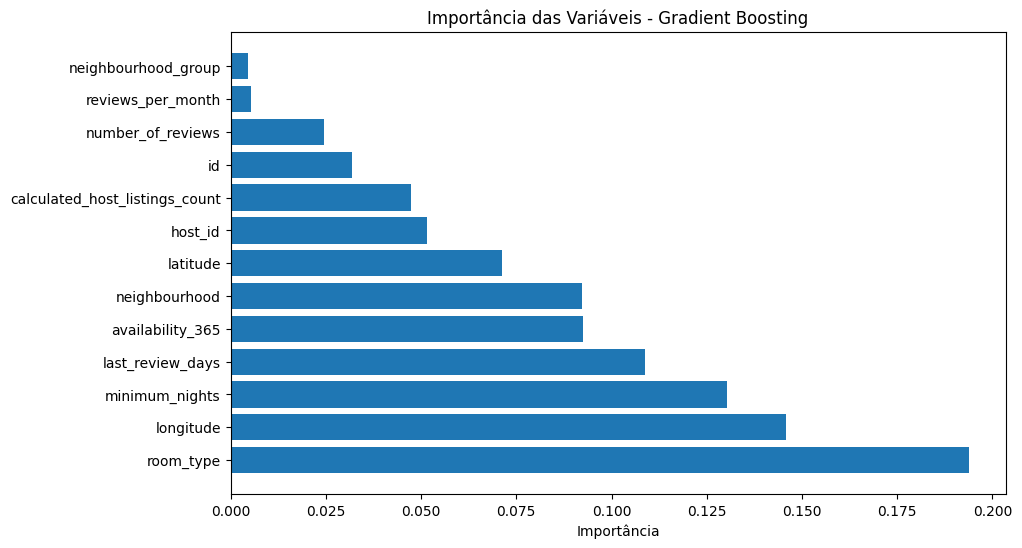

In [ ]:
# Passo 7: Visualização da Importância das Variáveis (para Gradient Boosting)
importances = gb_model.feature_importances_
indices = importances.argsort()[::-1]  # Ordenando pela importância (do maior para o menor)

plt.figure(figsize=(10, 6))
plt.title("Importância das Variáveis - Gradient Boosting")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), [X.columns[i] for i in indices])
plt.xlabel("Importância")
plt.show()

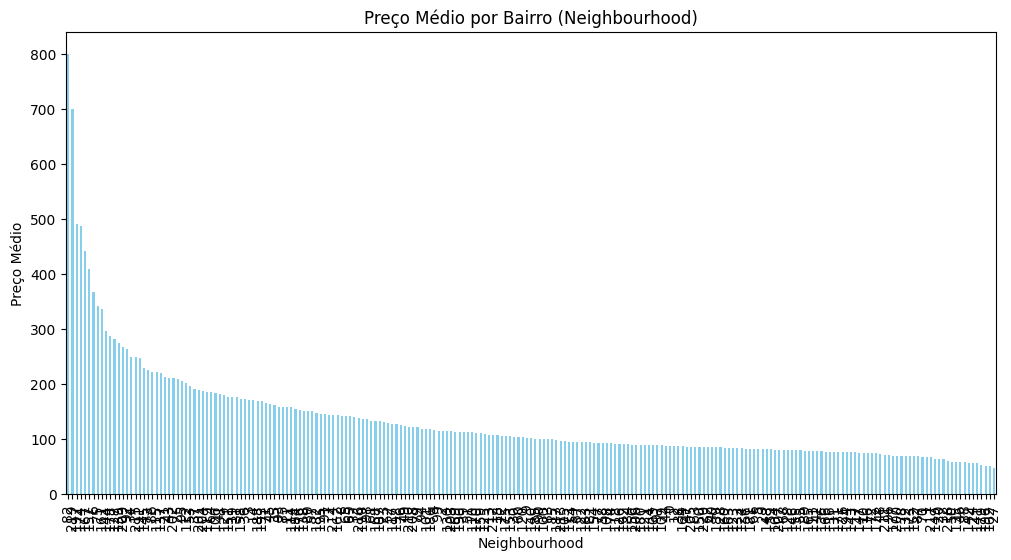

In [ ]:
# Passo 8: Exploração do Preço por Região
neighbourhood_price = df.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)

# Visualizando os preços médios por bairro
plt.figure(figsize=(12, 6))
neighbourhood_price.plot(kind='bar', color='skyblue')
plt.title('Preço Médio por Bairro (Neighbourhood)')
plt.xlabel('Neighbourhood')
plt.ylabel('Preço Médio')
plt.xticks(rotation=90)
plt.show()

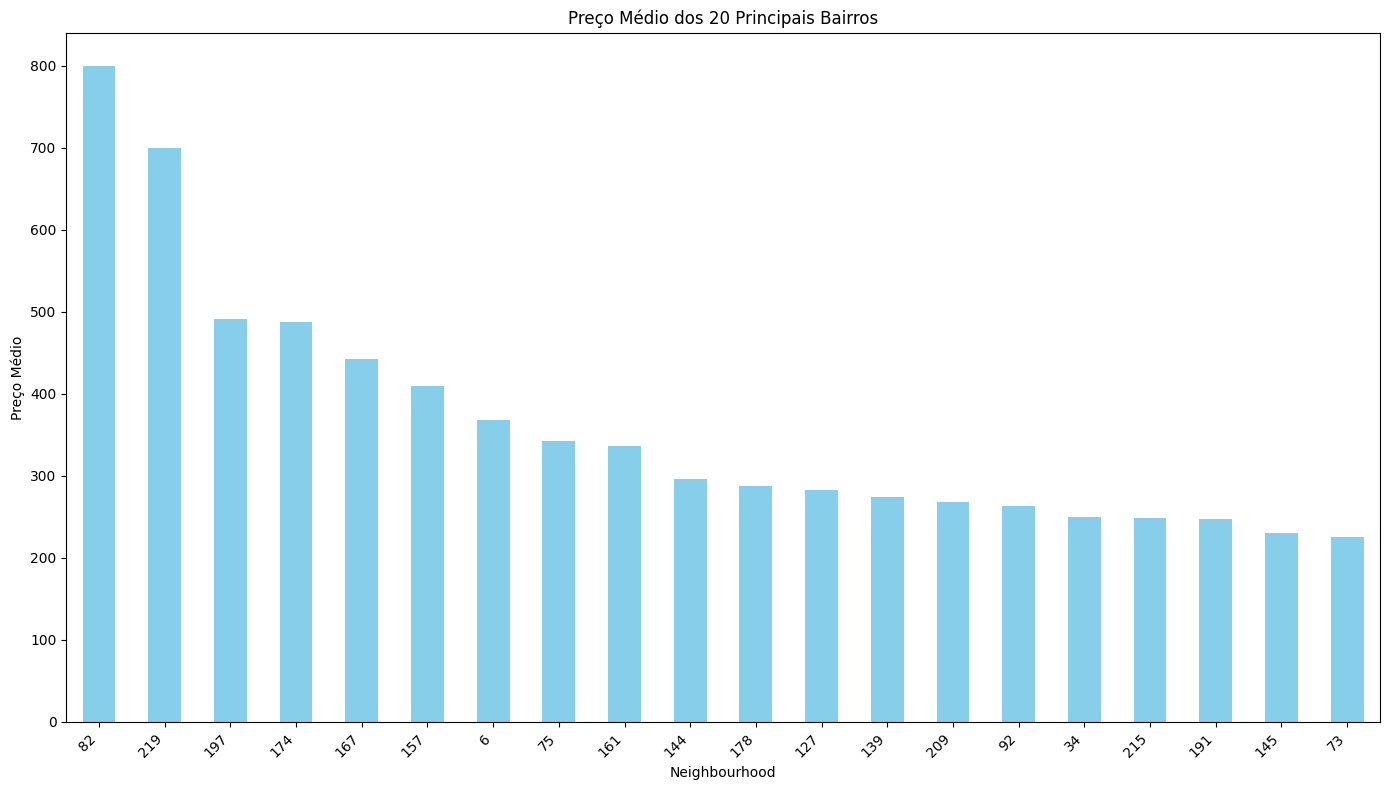

In [ ]:
# Passo 8.1: Limitando para os 20 bairros com maiores preços médios.
top_neighbourhoods = neighbourhood_price.head(20)

plt.figure(figsize=(14, 8))
top_neighbourhoods.plot(kind='bar', color='skyblue')

plt.title('Preço Médio dos 20 Principais Bairros')
plt.xlabel('Neighbourhood')
plt.ylabel('Preço Médio')

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

plt.show()


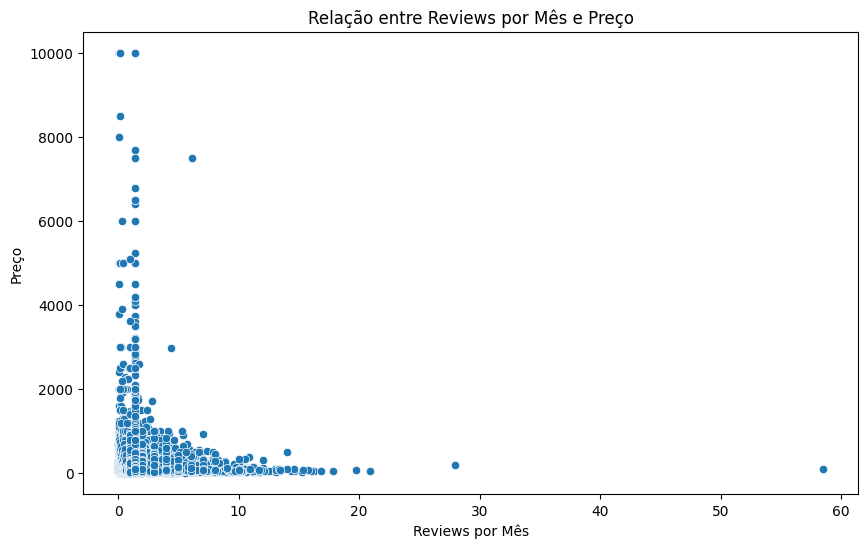

In [ ]:
# Passo 9: Analisando a Interação de Variáveis - Reviews por Mês e Preço
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['reviews_per_month'], y=df['price'])
plt.title('Relação entre Reviews por Mês e Preço')
plt.xlabel('Reviews por Mês')
plt.ylabel('Preço')
plt.show()

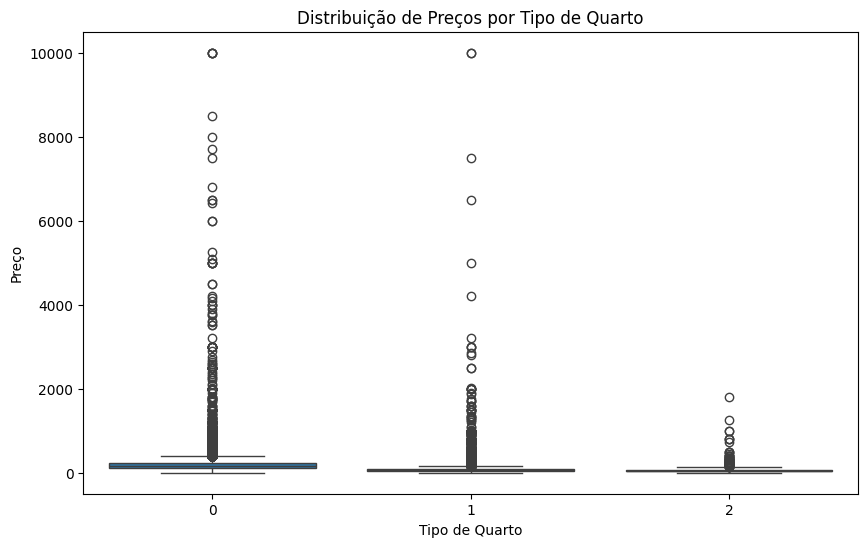

In [ ]:
# Passo 10: Boxplot de Preço por Tipo de Quarto
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['room_type'], y=df['price'])
plt.title('Distribuição de Preços por Tipo de Quarto')
plt.xlabel('Tipo de Quarto')
plt.ylabel('Preço')
plt.show()


Erro Quadrático Médio com profundidade 10: 46319.80777053515


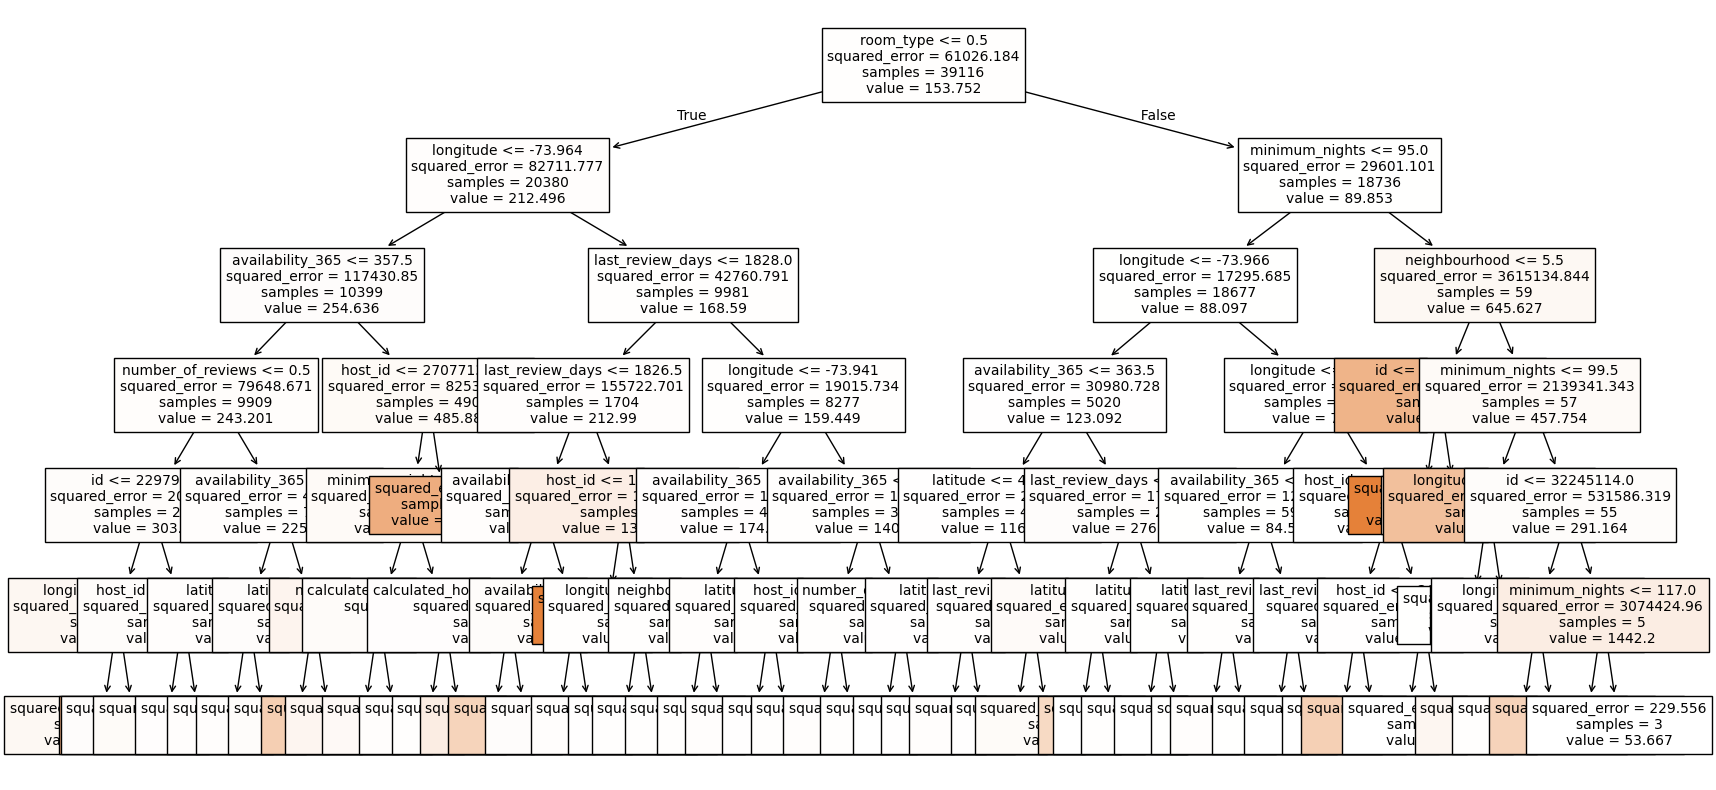

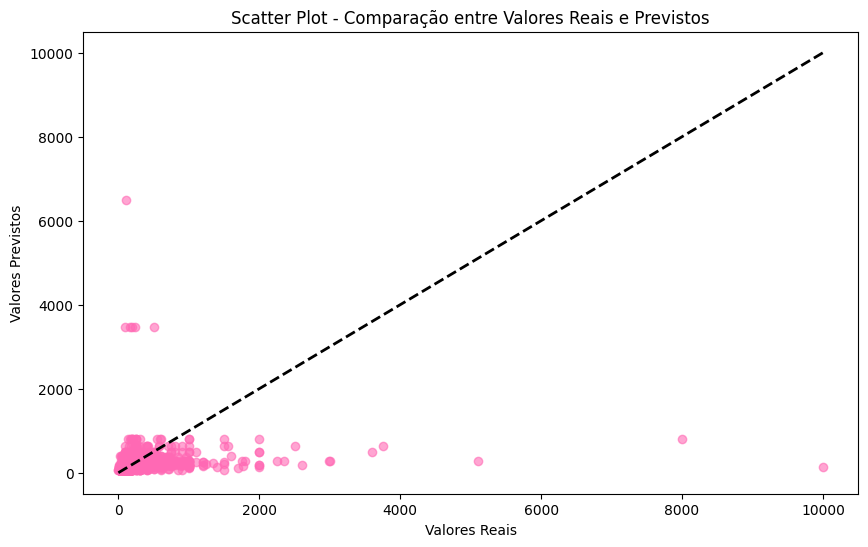

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
# Modelo 2.1: DecisionTreeRegressor com profundidade máxima 6
model_2 = DecisionTreeRegressor(max_depth=6)
model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_test)
mse_2 = mean_squared_error(y_test, y_pred_2)
print(f'Erro Quadrático Médio com profundidade 6: {mse_2}')

plt.figure(figsize=(20,10))
plot_tree(model_2, filled=True, feature_names=X_train.columns, fontsize=10)
plt.show()

# Scatter Plot para comparar os valores reais e previstos
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_2, color="#FF69B4", alpha=0.6)  # Usando cor rosinha estilo Airbnb
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Linha de referência y=x
plt.xlabel("Valores Reais")
plt.ylabel("Valores Previstos")
plt.title("Scatter Plot - Comparação entre Valores Reais e Previstos")
plt.show()

Erro Quadrático Médio com profundidade 4: 43021.024300150515


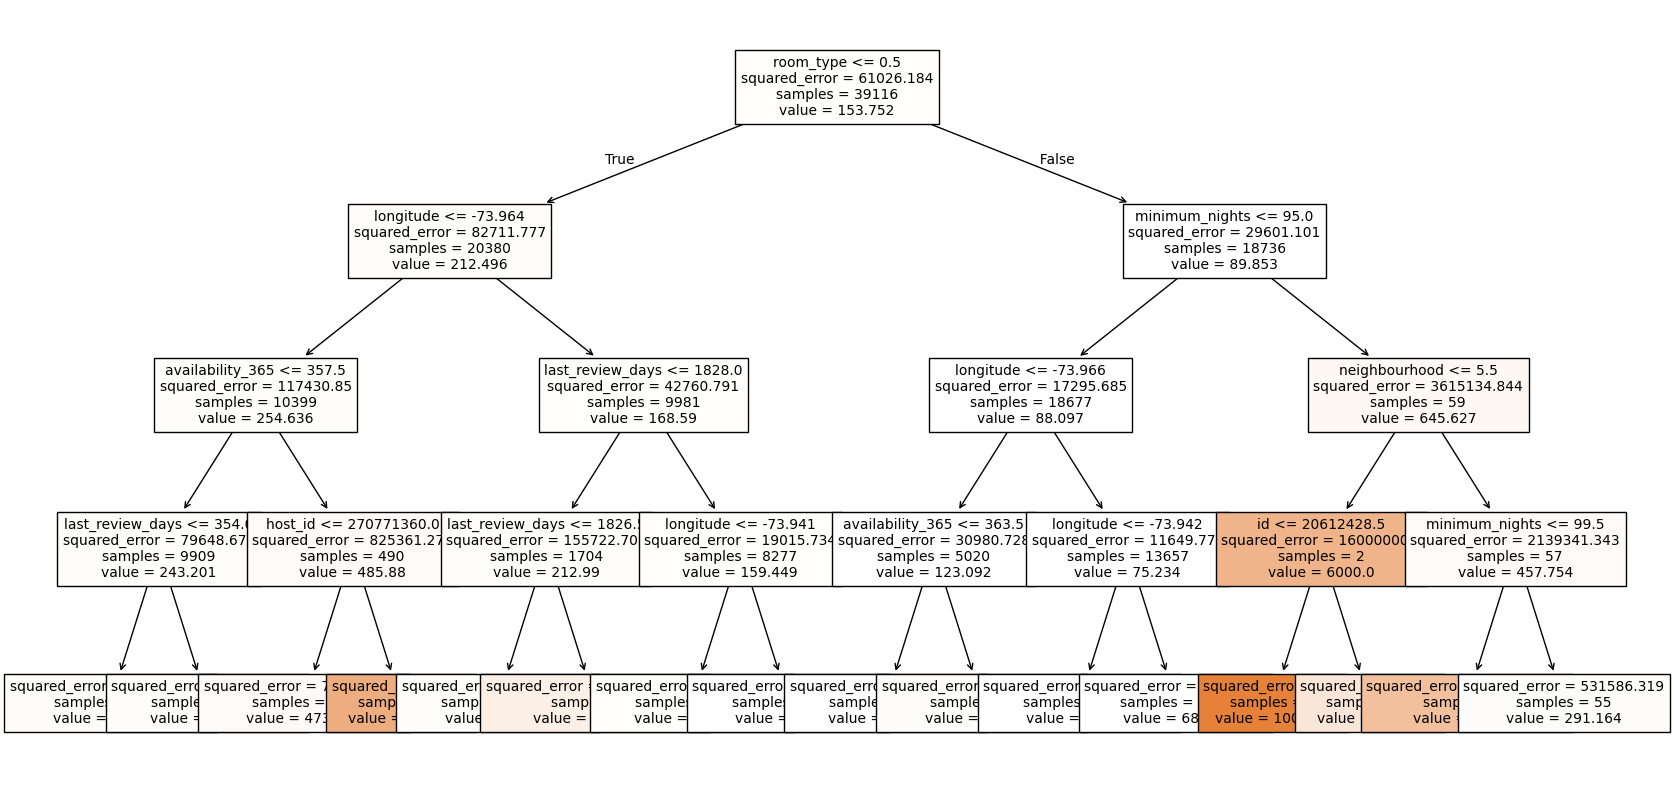

In [ ]:

# Modelo 2.2: DecisionTreeRegressor com profundidade máxima 4
model_2 = DecisionTreeRegressor(max_depth=4)
model_2.fit(X_train, y_train)

# Fazendo previsões
y_pred_2 = model_2.predict(X_test)

# Calculando o Erro Quadrático Médio
mse_2 = mean_squared_error(y_test, y_pred_2)
print(f'Erro Quadrático Médio com profundidade 4: {mse_2}')

# Plota a árvore de decisão
plt.figure(figsize=(20,10))  # Ajuste o tamanho da figura conforme necessário
plot_tree(model_2, filled=True, feature_names=X_train.columns, fontsize=10)
plt.show()


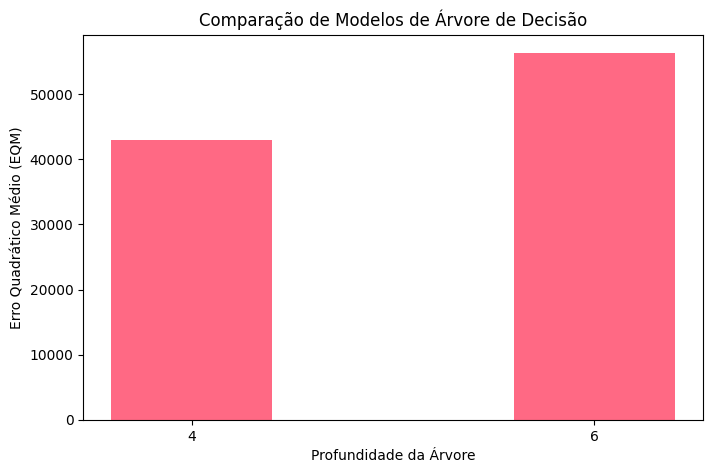

In [ ]:
#comparação dos arbores profundidade 4 e 6
profundidades = [4, 6]
erros_qm = [43021.0243, 56322.0462]

plt.figure(figsize=(8, 5))
plt.bar(profundidades, erros_qm, color="#FF6984")
plt.xlabel("Profundidade da Árvore")
plt.ylabel("Erro Quadrático Médio (EQM)")
plt.title("Comparação de Modelos de Árvore de Decisão")
plt.xticks(profundidades)
plt.show()

In [ ]:
# Random Forest: Treinando o modelo com 100 árvores
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Erro Quadrático Médio do Random Forest: {mse_rf}')

Erro Quadrático Médio do Random Forest: 35146.61494904387


In [ ]:
# Ajustando mais parâmetros no Random Forest
rf_model_tuned = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=20,
    random_state=42
)
rf_model_tuned.fit(X_train, y_train)
y_pred_rf_tuned = rf_model_tuned.predict(X_test)
mse_rf_tuned = mean_squared_error(y_test, y_pred_rf_tuned)
print(f'Erro Quadrático Médio do Random Forest Ajustado: {mse_rf_tuned}')

Erro Quadrático Médio do Random Forest Ajustado: 35230.10966505764


In [ ]:
# Visualização da Importância das Variáveis
importances = rf_model.feature_importances_
indices = importances.argsort()[::-1]

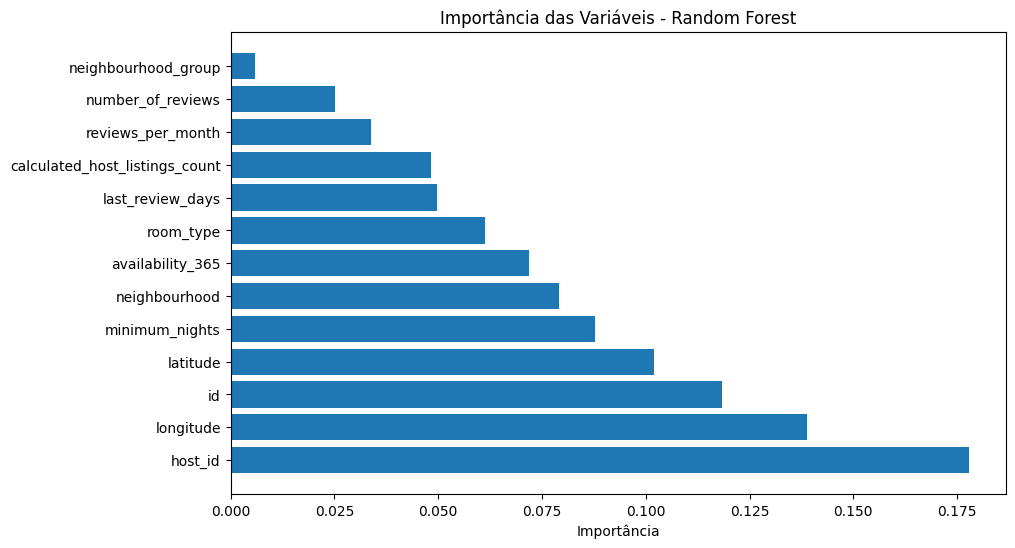

In [ ]:
# Random Forest
plt.figure(figsize=(10, 6))
plt.title("Importância das Variáveis - Random Forest")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), [X.columns[i] for i in indices])
plt.xlabel("Importância")
plt.show()

In [ ]:
#Curva Roc.
threshold = 100
y_bin = (y > threshold).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

rf_model_bin = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_bin.fit(X_train, y_train)

y_prob = rf_model_bin.predict(X_test)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)


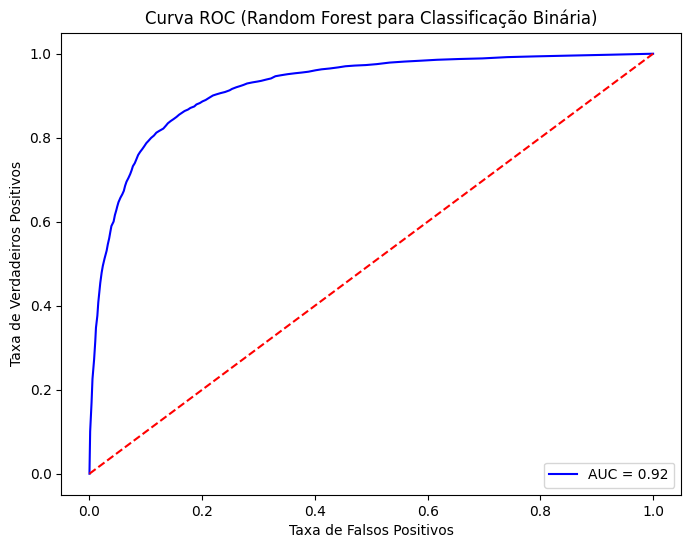

In [ ]:
# Plotando a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC (Random Forest para Classificação Binária)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Exibindo a AUC - Detalhada na parte inferior do gráfico.
print(f'AUC: {roc_auc}')

AUC: 0.9212438045571888


Matriz de Confusão:
[[4109  744]
 [ 725 4201]]


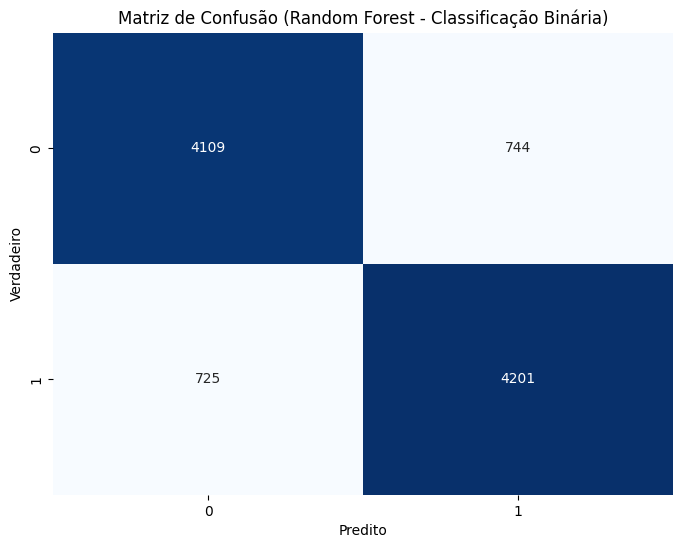

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4853
           1       0.85      0.85      0.85      4926

    accuracy                           0.85      9779
   macro avg       0.85      0.85      0.85      9779
weighted avg       0.85      0.85      0.85      9779



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

# Matriz de confusão.
threshold = 100
y_bin = (y > threshold).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

rf_model_bin = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_bin.fit(X_train, y_train)

y_pred_bin = rf_model_bin.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_bin)
print("Matriz de Confusão:")
print(conf_matrix)

# Visualizando a matriz de confusão.
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão (Random Forest - Classificação Binária)")
plt.show()

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_bin))

Melhor valor de k para KNN: 11


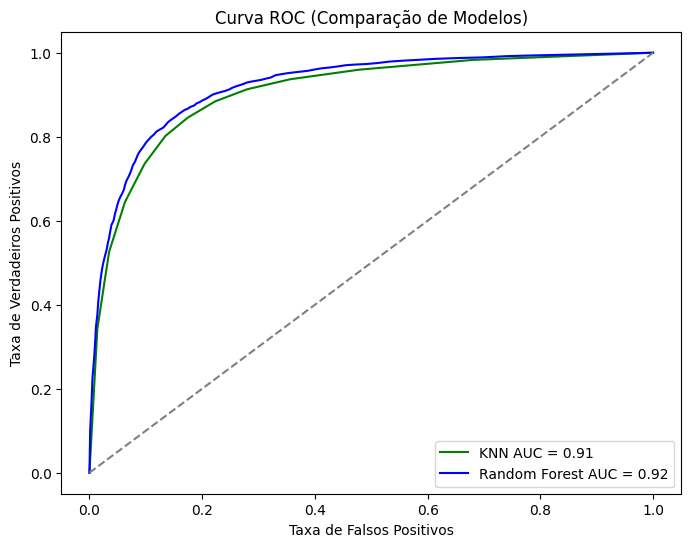

AUC do modelo KNN: 0.91


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Ajustando os hiperparâmetros do KNN
knn_param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
knn_grid_search.fit(X_train, y_train)

best_k = knn_grid_search.best_params_['n_neighbors']
print(f'Melhor valor de k para KNN: {best_k}')

knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)

y_prob_knn = knn_model.predict_proba(X_test)[:, 1]

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plotando a Curva ROC para KNN
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='green', label=f'KNN AUC = {roc_auc_knn:.2f}')
plt.plot(fpr, tpr, color='blue', label=f'Random Forest AUC = {roc_auc:.2f}')  # Comparando com Random Forest
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha diagonal
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC (Comparação de Modelos)')
plt.legend(loc='lower right')
plt.show()

# Exibindo a AUC para o modelo KNN
print(f'AUC do modelo KNN: {roc_auc_knn:.2f}')


In [ ]:
num_amostras = df.shape[0]
print(f"O dataset possui {num_amostras} amostras.")

O dataset possui 48895 amostras.


In [ ]:
print(df.columns)


NameError: name 'df' is not defined